## Workbook to create the subsetted df of block groups that are intersected with flare buffers or adjacent to those intersected BGs.
#### It was easier to just spin this into a separate notebook rather than trying to get the correct df out of my existing functions. Better not to risk breaking things.

In [2]:
import geopandas as gp
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import pandas as pd
import numpy as np
from pprint import pprint
import os
import glob
import openpyxl


In [3]:
# just CA flares
ca_flares = gp.read_file("data/ca_flares_clean.shp")
print(f'Flares found: {len(ca_flares)}')

# CA block groups merged with EJscreen data
ca_bg_joined = gp.read_file("data/ca_bg_joined_clean.shp", dtype={'bg_id': 'int', 'index':'int'})

# update col name for correct area b/c it gets saved as a truncated version when saved as a shapefile out of the 
# main data cleaning notebook
ca_bg_joined.rename(columns={'shape_ar_1':'shape_area_new'}, inplace=True)  # old:new.
print(f'BGs found: {len(ca_bg_joined)}')

Flares found: 117
BGs found: 25607


In [4]:
# set common crs for project
# epsg3310: https://epsg.io/3310-1739
# units: meters
meters_crs = 3310  # Projected crs. this should be good for this overlay() calculation and all of project. 

#ca_state = ca_state.to_crs(meters_crs)
#ca_counties = ca_counties.to_crs(meters_crs)
ca_bg_joined = ca_bg_joined.to_crs(meters_crs)

In [5]:
# There are five BGs that seem to just be aquatic buffers around the actual county land.
# Dropping them for now 
# Explore if needed: ca_bg_joined.explore()

ids_to_drop = [60839900000, 61119901000, 60379902000, 60379903000, 60599901000]

# Drop the rows with those IDs
ca_bg_joined = ca_bg_joined[~ca_bg_joined['bg_id'].isin(ids_to_drop)]

ca_bg_joined.rename(columns={'geometry':'bg_geom'}, inplace=True)  # old:new. Match col names for merging

In [7]:
social_df = ca_bg_joined
flares_df = ca_flares
buffer_size=2000

social_df = social_df.set_geometry('bg_geom')

#flares_df = set_geometry_buffer(flares_df, buffer_size)
buffer_col = f"buffer_{buffer_size}m"
flares_df[buffer_col] = flares_df['geometry'].buffer(distance=buffer_size)

flares_df = flares_df.set_geometry(buffer_col)

temp = flares_df.unary_union
all_buffers = gp.GeoDataFrame({'geometry': [temp]}, crs=flares_df.crs)  # convert back to geodf for processing

In [10]:
intersect_portions = gp.overlay(social_df, all_buffers, how='')  # could look at keep_geom=False

intersect_portions.rename(columns={'geometry':'intersect_geom'}, inplace=True)  # old:new. Match col names for merging

In [13]:
intersect_portions = intersect_portions.set_geometry('intersect_geom')

In [19]:

social_df = social_df.set_geometry('bg_geom')

# Mask for filtering social_df down to just intersected BGs
intersect_portions_temp = intersect_portions
intersect_portions_temp = intersect_portions_temp.set_geometry('intersect_geom')
intersect_mask = intersect_portions_temp['bg_id'].unique()

# Create filtered df of all intersected BGs plus adjacent BGs to those intersected
intersect_bgs = social_df[social_df['bg_id'].isin(intersect_mask)]
intersect_bgs = intersect_bgs.set_geometry('bg_geom')  # set to the buffers rather than the points

# the intersection of the intersect_bgs df and the original social_df gives us a 
# df of all intersected and adjacent-to-the-intersected BGs.
inter_adj_df = gp.sjoin(social_df, intersect_bgs, how = "inner", predicate = 'intersects')

# clean up extra cols after the sjoin() and drop duplicates
inter_adj_df = inter_adj_df.loc[:, ~inter_adj_df.columns.str.endswith('_right')]
inter_adj_df.columns = inter_adj_df.columns.str.replace('_left', '')
inter_adj_df = inter_adj_df.drop_duplicates(subset=['bg_id'])


<AxesSubplot:>

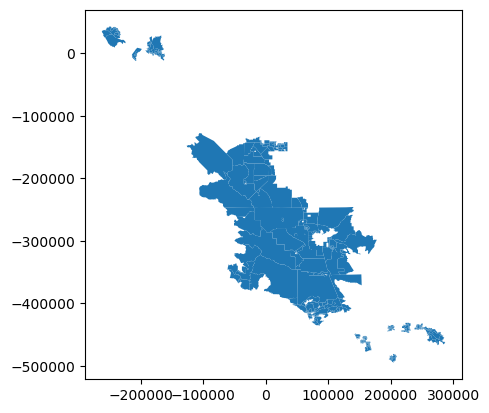

In [21]:
inter_adj_df.plot()

In [24]:
inter_adj_df = inter_adj_df[['bg_geom']].copy()

In [25]:
inter_adj_df

,bg_geom
2,"POLYGON ((152442.207 -458985.139, 152441.728 -..."
3,"POLYGON ((152453.177 -459429.971, 152452.671 -..."
10209,"POLYGON ((152437.669 -458782.561, 152452.350 -..."
13516,"POLYGON ((153261.185 -459807.337, 153260.998 -..."
13574,"POLYGON ((154048.319 -458923.580, 154103.458 -..."
...,...
20298,"POLYGON ((-239270.581 39818.813, -239267.613 3..."
17837,"POLYGON ((-237091.211 36527.226, -237089.934 3..."
17838,"POLYGON ((-236818.509 39037.411, -236796.802 3..."
17839,"POLYGON ((-237016.373 36931.774, -237011.591 3..."


In [26]:
inter_adj_df.to_file('data/df_inter_adj_geo.shp', driver='ESRI Shapefile')